
# Catboost

In [ ]:
import datetime
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder

from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve



import lightgbm as lgb
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier




#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import shap

# import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [ ]:
input_path = './input/xiaoerxiaochuan/'
output_path = './output/GBDT/'

In [ ]:
# pd.set_option('max_columns',100)
# pd.set_option('max_rows',900)

pd.set_option('max_colwidth',200)

df = pd.read_excel(input_path+'data.xlsx')
df = df.dropna(axis=0,subset=['咳嗽分型']).reset_index()
df.drop(index=[11,82],inplace=True)

In [ ]:
medicines = []
for i in df.columns:
    if re.match('药\d$',i):
        medicines += df[i].tolist()
medicines = list(set(medicines))
for item in ['？', np.nan, '1.桑白皮', '（1）炙黄芪', '（1）桑叶', '葶苈子（包）', '地肤子（包）', '黛蛤散','葶苈子（包)','葶苈','白']:
    if item in medicines:
        medicines.remove(item)
X = pd.DataFrame()
for i,row in df.iterrows():
    for j in row:
        if j in medicines:
            X.loc[i,j] = row[str(row[row==j].index.tolist()[0])+'剂量(g)']
X.replace(np.nan,0,inplace=True)
X['桑叶/桑白皮'].replace('各\d',4,regex=True,inplace=True)
X['煅龙牡'].replace('各\d',4,regex=True,inplace=True)
y = df['咳嗽分型']
y.iplot(kind='hist', title= '咳嗽分型')
X = pd.concat([X,y],axis=1)
X = X.drop(X[(X['咳嗽分型']!='热性哮喘') & (X['咳嗽分型'] != '寒性哮喘')].index)
X['咳嗽分型'].iplot(kind='hist', title= '咳嗽分型')

In [ ]:
accuracy= []
recall =[]
roc_auc= []
precision = []
le = LabelEncoder()

In [ ]:
X

In [ ]:
y

In [ ]:
y = X['咳嗽分型']
y = le.fit_transform(y)
X.drop(columns='咳嗽分型',inplace=True)
cols = X.columns
X

In [ ]:
scale = StandardScaler()
X =scale.fit_transform(X)

In [ ]:
X

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost_5 = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=3,allow_writing_files=False)


catboost_5.fit(X_train, y_train,eval_set=(X_test, y_test))

y_pred = catboost_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['Catboost_adjusted_weight_3']
result_df3 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df3

In [ ]:
catboost_feature_importances=pd.DataFrame(data=[catboost_5.feature_importances_],columns=cols).sort_values(by=0,axis=1,ascending=False)
# list(catboost_feature_importances.columns)
plt.bar(catboost_feature_importances.columns[:10],catboost_feature_importances.values.squeeze()[:10])

In [ ]:
catboost_feature_importances=pd.DataFrame(data=[catboost_5.get_feature_importance(type='PredictionValuesChange')],columns=cols).sort_values(by=0,axis=1,ascending=False)
plt.bar(catboost_feature_importances.columns[:10],catboost_feature_importances.values.squeeze()[:10])

In [ ]:
# catboost_feature_importances=pd.DataFrame(data=[catboost_5.get_feature_importance(type='ShapValues')],columns=cols).sort_values(by=0,axis=1,ascending=False)
# plt.bar(catboost_feature_importances.columns[:10],catboost_feature_importances.values.squeeze()[:10])

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 8))
# plot_confusion_matrix(catboost_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

In [ ]:
explainercat = shap.TreeExplainer(catboost_5)
shap_values_cat_test = explainercat.shap_values(X_test)
shap_values_cat_train = explainercat.shap_values(X_train)

In [ ]:
SHAP_CatBoost=pd.DataFrame(data=shap_values_cat_train,columns=cols).sum(axis=0).sort_values(ascending=False)
SHAP_CatBoost.drop(index=SHAP_CatBoost[SHAP_CatBoost==0].index,inplace=True)
SHAP_CatBoost.round(3).to_csv(output_path+'Catboost_SHAP.csv')

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
shap.summary_plot(shap_values_cat_train, cols, plot_type="bar",plot_size=(8,8))

In [ ]:
# fig = plt.subplots(figsize=(6,6),dpi=200)
# ax = shap.summary_plot(shap_values_cat_train, cols,plot_type="dot")

# LightGBM

- split:分裂时，特征用到的次数
- gain:信息增益

In [ ]:
import re
from pprint import pprint
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
#from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import shap
# import missingno as msno
import warnings
warnings.filterwarnings("ignore")
print(datetime.datetime.now(),'\n依赖库加载完毕!')

In [ ]:
df = pd.read_excel(input_path+'data.xlsx')
df = df.dropna(axis=0,subset=['咳嗽分型']).reset_index()
df.drop(index=[11,82],inplace=True)
medicines = []
for i in df.columns:
    if re.match('药\d$',i):
        medicines += df[i].tolist()
medicines = list(set(medicines))
for item in ['？', np.nan, '1.桑白皮', '（1）炙黄芪', '（1）桑叶', '葶苈子（包）', '地肤子（包）', '黛蛤散','葶苈子（包)','葶苈','白']:
    if item in medicines:
        medicines.remove(item)
X = pd.DataFrame()
for i,row in df.iterrows():
    for j in row:
        if j in medicines:
            X.loc[i,j] = row[str(row[row==j].index.tolist()[0])+'剂量(g)']
X.replace(np.nan,0,inplace=True)
X['桑叶/桑白皮'].replace('各\d',4,regex=True,inplace=True)
X['煅龙牡'].replace('各\d',4,regex=True,inplace=True)
y = df['咳嗽分型']
# y.iplot(kind='hist', title= '咳嗽分型')
X = pd.concat([X,y],axis=1)
X = X.drop(X[(X['咳嗽分型']!='热性哮喘') & (X['咳嗽分型'] != '寒性哮喘')].index)
# X['咳嗽分型'].iplot(kind='hist', title= '咳嗽分型')
accuracy= []
recall =[]
roc_auc= []
precision = []
le = LabelEncoder()
y = X['咳嗽分型']
y = le.fit_transform(y)
X.drop(columns='咳嗽分型',inplace=True)
cols = X.columns
X[:] = StandardScaler().fit_transform(X)
print(datetime.datetime.now(),'\n数据预处理完成!')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lgbmc_5=lgb.LGBMClassifier(random_state=0,scale_pos_weight=3)

lgbmc_5.fit(X_train, y_train,categorical_feature = 'auto',eval_set=(X_test, y_test),feature_name='auto', verbose=0)

y_pred = lgbmc_5.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

model_names = ['LightGBM_adjusted_weight_5']
result_df9 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)
result_df9

In [ ]:
lgb_feature_importances=pd.DataFrame(data=[lgbmc_5.feature_importances_],columns=cols).sort_values(by=0,axis=1,ascending=False)
plt.bar(lgb_feature_importances.columns[:10],lgb_feature_importances.values.squeeze()[:10])

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 8))
# plot_confusion_matrix(lgbmc_5, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

In [ ]:
from lightgbm import plot_importance
_,ax = plt.subplots(figsize=(10,8))
plot_importance(lgbmc_5,importance_type='split',grid=False,height=0.5,ax=ax,max_num_features=10)

In [ ]:
_,ax = plt.subplots(figsize=(10,8))
plot_importance(lgbmc_5,importance_type='gain',grid=False,height=0.5,ax=ax,max_num_features=10)

In [ ]:
from sklearn.inspection import permutation_importance
lgb_permutation_importance = permutation_importance(lgbmc_5,X_test,y_test,random_state=77)
sorted_idx = lgb_permutation_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx][:10],lgb_permutation_importance.importances_mean[sorted_idx][:10])
plt.xlabel("Permutation Importance")
# lgb_permutation_importance.importances_mean[sorted_idx][:10]

In [ ]:
explainerlgbmc = shap.TreeExplainer(lgbmc_5)
shap_values_LightGBM_test = explainerlgbmc.shap_values(X_test)
shap_values_LightGBM_train = explainerlgbmc.shap_values(X_train)
print(datetime.datetime.now(),'LightGBM SHAP value训练完成!')

In [ ]:
SHAP_LightGBM=pd.DataFrame(data=shap_values_LightGBM_train[1],columns=cols).sum(axis=0).sort_values(ascending=False)
SHAP_LightGBM.drop(index=SHAP_LightGBM[SHAP_LightGBM==0].index,inplace=True)
SHAP_LightGBM.to_csv(output_path+'LightGBM_SHAP.csv')

In [ ]:
shap.summary_plot(shap_values_LightGBM_train[1],cols,plot_type="bar",plot_size=(12,12))

In [ ]:
# fig = plt.subplots(figsize=(6,6),dpi=200)
# ax = shap.summary_plot(shap_values_LightGBM_train[1], cols,plot_type="dot")

# XGBoost

- 信息增益gain：节点分裂时，该特征带来的信息增益优化的平均值
- 权重weight: 子树模型分裂时，用到的特征次数
- cover:特征下的叶子节点涵盖的样本数除以用来分裂的次数，分裂越靠近根部，cover越大
- permutation:如果这个特征很重要，那么我们打散样本中该特征的值，最后优化目标将折损，这个折损程度就是这个特征的重要程度，对非线性模型更加友好
- SHAP: 轮流去掉每一个特征，算出剩下的特征的贡献情况，以此来推导出特征的边际贡献


In [ ]:
import re
from pprint import pprint
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,cross_val_predict, train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve
import lightgbm as lgb
from xgboost import XGBClassifier
import xgboost as xgb
#from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier
#importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import shap
# import missingno as msno
import warnings
warnings.filterwarnings("ignore")
print(datetime.datetime.now(),'\n依赖库加载完毕!')

In [ ]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
print(datetime.datetime.now(),'\nmatplotlib中文设置完成!')

In [ ]:
df = pd.read_excel('./input/xiaoerxiaochuan/data.xlsx')

 '制僵蚕', '天麦门冬', '姜半夏', '川桂枝', '川连', '干地龙', '广地龙',  '杏仁', '桑叶/桑白皮', '桑叶皮', '法半夏', '炙乌梅', '炙乌梢', '炙冬瓜', '炙冬花', '炙甘草', '炙百部', '炙百郭', '炙紫菀',  '炙麻黄', '炙黄芪', '炙黄花', '炙黄花 ', '焦山楂', '焦神曲', '煅牡蛎', '煅龙牡', '煅龙牡各', '煅龙骨', '生地', '生大黄', '生甘草', '生石膏', '白芎', '百合部', '碧桃干', '紫苑', '芎藭', '苍白术', '苏叶', '草河车', '葶苏子', '薄黄', '藿香', '蚤休', '黄苓',


In [ ]:
to_replace = ['全瓜蒌','戴蛤散','炙紫苑','炙麻花','紫苑','黄岑','黛蛤散','煅龙牡各','制僵蚕']
to_place_value = ['瓜蒌','黛蛤散','炙紫菀','炙麻黄','紫菀','黄芩','黛蛤散','煅龙牡','僵蚕']
df = pd.read_excel('./input/xiaoerxiaochuan/data.xlsx')
df.replace(to_replace=to_replace,value=to_place_value,inplace=True)
df = df.dropna(axis=0,subset=['咳嗽分型']).reset_index()
df.drop(index=[11,82],inplace=True)
medicine_split_list = ['天麦门冬','桑叶/桑白皮','煅龙牡','百合部','苍白术','葶苏子']

In [ ]:
medicines = []
for i in df.columns:
    if re.match('药\d$',i):
        medicines += df[i].tolist()
medicines = list(set(medicines))
for item in ['？', np.nan, '1.桑白皮', '（1）炙黄芪', '（1）桑叶', '地肤子（包）', '黛蛤散','葶苈子（包)','葶苈','白']:
    if item in medicines:
        medicines.remove(item)
X = pd.DataFrame()
for i,row in df.iterrows():
    for j in row:
        if j in medicines:
            X.loc[i,j] = row[str(row[row==j].index.tolist()[0])+'剂量(g)']
X.replace(np.nan,0,inplace=True)
X['桑叶/桑白皮'].replace('各\d',4,regex=True,inplace=True)
X['煅龙牡'].replace('各\d',4,regex=True,inplace=True)
y = df['咳嗽分型']
# y.iplot(kind='hist', title= '咳嗽分型')
X = pd.concat([X,y],axis=1)
X = X.drop(X[(X['咳嗽分型']!='热性哮喘') & (X['咳嗽分型'] != '寒性哮喘')].index)
# X['咳嗽分型'].iplot(kind='hist', title= '咳嗽分型')
accuracy= []
recall =[]
roc_auc= []
precision = []
le = LabelEncoder()
y = X['咳嗽分型']
y = le.fit_transform(y)
X.drop(columns='咳嗽分型',inplace=True)
cols = X.columns
X[:] = StandardScaler().fit_transform(X.values)
print(datetime.datetime.now(),'\n数据预处理完成!')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgbc_3 = xgb.XGBClassifier(random_state=0,scale_pos_weight=3,booster='gbtree',eval_metric='error')

xgbc_3.fit(X_train, y_train)
y_pred = xgbc_3.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred),4))
recall.append(round(recall_score(y_test, y_pred),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
precision.append(round(precision_score(y_test, y_pred),4))

print(f"accuracy:{sum(accuracy)/5:.3f}\n",f"recall:{sum(recall)/5:.3f}\n",f"roc_auc:{sum(roc_auc)/5:.3f}\n",f"precision{sum(precision)/5:.3f}\n")

In [ ]:
# 权重weight:在子树模型分裂时，用到的特征次数
# from xgboost import plot_importance
# _,ax = plt.subplots(figsize=(10,8))
# plot_importance(xgbc_3,importance_type='weight',grid=False,height=0.5,ax=ax,max_num_features=10)

In [ ]:
# _,ax = plt.subplots(figsize=(10,8))
# plot_importance(xgbc_3,importance_type='gain',grid=False,height=0.5,ax=ax,max_num_features=10)

In [ ]:
# _,ax = plt.subplots(figsize=(10,8))
# plot_importance(xgbc_3,importance_type='cover',grid=False,height=0.5,ax=ax,max_num_features=10)

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 8))
# plot_confusion_matrix(xgbc_3, X_test, y_test, cmap=plt.cm.Blues, ax=ax);

## SHAP Feature Importance


In [ ]:
explainerxgbc = shap.TreeExplainer(xgbc_3)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)
print(datetime.datetime.now(),"\nXGBoost SHAP value训练完成!")

In [ ]:
# shap_values_XGBoost_train

In [ ]:
SHAP_XGBoost=pd.DataFrame(data=shap_values_XGBoost_train,columns=X_train.columns).mean(axis=0).sort_values(ascending=False)
SHAP_XGBoost.drop(index=SHAP_XGBoost[SHAP_XGBoost==0].index,inplace=True)
SHAP_XGBoost.round(3).to_csv(output_path+'XGBoost_SHAP.csv')
print(datetime.datetime.now())

In [ ]:
# shap.summary_plot(shap_values_XGBoost_train, cols,plot_type="bar",plot_size=(12,12))

In [ ]:
# from sklearn.inspection import permutation_importance
# xgb_permutation_importance = permutation_importance(xgbc_3,X_test,y_test,random_state=77)
# sorted_idx = xgb_permutation_importance.importances_mean.argsort()
# plt.barh(X.columns[sorted_idx][:10],xgb_permutation_importance.importances_mean[sorted_idx][:10])
# plt.xlabel("Permutation Importance")

## 中药

In [ ]:
# import pandas as pd
# total = pd.DataFrame()
# with pd.ExcelWriter('./input/xiaoerxiaochuan/汇总.xlsx') as writer:
#     for i in pd.ExcelFile('./input/xiaoerxiaochuan/test.xlsx').sheet_names:
#         data = pd.read_excel('./input/xiaoerxiaochuan/test.xlsx',sheet_name=i)
#         total = pd.concat([total,data],axis=0)
#         data.to_excel(writer,header=True,sheet_name=i)
#     total.reset_index(inplace=True,drop=True)
#     total.drop(index=[36,37,38],inplace=True)
#     total.to_excel(writer,sheet_name='汇总',header=True,index=False)
# pd.read_excel('./input/xiaoerxiaochuan/汇总.xlsx',sheet_name='汇总')

In [ ]:
import pandas as pd
zy_dict = pd.read_excel('./input/xiaoerxiaochuan/汇总.xlsx',sheet_name='汇总')

zy_dict.tail(5)

In [ ]:
# SHAP_XGBoost = pd.DataFrame(data=SHAP_XGBoost,columns=['SHAP_Value'])
# SHAP_XGBoost
SHAP_XGBoost

In [ ]:
set(SHAP_XGBoost.index)-set(list(zy_dict['药名']))

# 心总表

In [1]:
import pandas as pd
import datetime
import missingno as msno
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
print(datetime.datetime.now())
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
from sklearn.metrics import accuracy_score,classification_report, recall_score,confusion_matrix, roc_auc_score, precision_score, f1_score, roc_curve, auc, plot_confusion_matrix,plot_roc_curve

2022-06-15 15:52:52.848995


In [13]:
xzb = pd.read_excel('./input/心总表.xlsx',sheet_name='总表')
xzb.tail()

,证名,病案号,性别,年龄,S1,S2,S3,S4,S5,S6,...,S116,S117,S118,S119,S120,S121,S122,S123,S124,S125
1738,4.0,152769.0,1.0,71.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
1739,3.0,130013.0,2.0,70.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
1740,4.0,176082.0,1.0,73.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.00000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000
1741,NaN,NaN,NaN,NaN,5.000000,9.000000,18.000000,8.000000,8.000000,4.000000,...,696.00000,147.000000,140.000000,193.000000,146.00000,15.000000,50.000000,260.000000,788.000000,100.000000
1742,NaN,NaN,NaN,NaN,0.002872,0.005169,0.010339,0.004595,0.004595,0.002298,...,0.39977,0.084434,0.080414,0.110856,0.08386,0.008616,0.028719,0.149339,0.452613,0.057438


<AxesSubplot:>

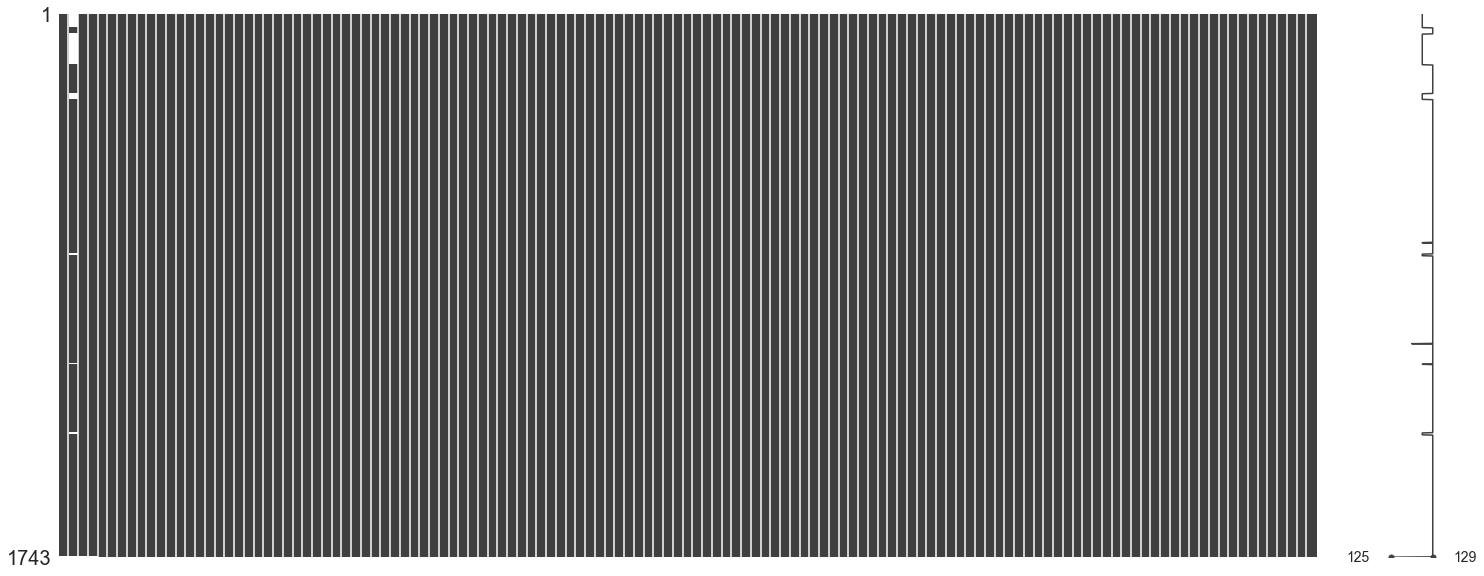

In [3]:
msno.matrix(xzb)

In [14]:
xzb.drop(columns=['病案号'],inplace=True)
xzb.drop(labels=[1742,1741],axis=0,inplace=True)
xzb.drop(labels=xzb[xzb['性别'].isna() ].index,inplace=True)
xzb = xzb.astype(int)
xzb.tail(5)

,证名,性别,年龄,S1,S2,S3,S4,S5,S6,S7,...,S116,S117,S118,S119,S120,S121,S122,S123,S124,S125
1736,1,1,66,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1737,1,1,71,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1738,4,1,71,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1739,3,2,70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1740,4,1,73,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0


In [15]:
xzb['证名'].astype(int).value_counts().iplot(kind='bar')
# xzb['证名'].value_counts()

In [ ]:
# xzb['性别'].astype(int).value_counts().iplot(kind='bar')

In [ ]:
# xzb['年龄'].astype(int).value_counts().iplot(kind='bar')

In [16]:
y = xzb['证名']
X = xzb.drop(labels=['证名','性别','年龄'],axis=1)
print(datetime.datetime.now())

2022-06-15 16:52:52.519999


## pearson相关系数
### 适用范围
- 线性数据、连续且符合正态分布
- 观测值是成对的，每对观测值之间是相互独立的
## Spearman等级相关系数
### 适用范围
- 对原变量的分布不做要求，适用那些不服从正态分布的数据，还有总体分布未知和原始数据用等级表示的数据
## kendall Rank相关系数
###


In [ ]:
# pearson相关系数
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# sns.heatmap(X.corr())

In [ ]:
# sns.heatmap(X.corr('kendall'))

In [ ]:
# sns.heatmap(X.corr('spearman'))

In [17]:
from collections import Counter
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.preprocessing import LabelEncoder
smote_tomek = SMOTETomek(random_state=0)
sme = SMOTEENN(random_state=0)
X_resampled,y_resampled= smote_tomek.fit_resample(X,y)
# X_resampled,y_resampled= sme.fit_resample(X,y)
le = LabelEncoder()
y_resampled = le.fit_transform(y_resampled)
sorted(Counter(y_resampled).items())

[(0, 3), (1, 379), (2, 179), (3, 272), (4, 69), (5, 483), (6, 280), (7, 365)]

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=77)

In [ ]:
# xzb_xgb = xgb.XGBClassifier(n_estimators=500,learning_rate=0.05,random_state=0,objective='multi:softmax',booster='gbtree',eval_metric='merror',use_label_encoder=False)
# xzb_xgb.fit(X_train, y_train)
# y_pred = xzb_xgb.predict(X_test)
# accuracy = []
# accuracy.append(round(accuracy_score(y_test, y_pred),4))
# accuracy
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=10,random_state=0,shuffle=True)
# xzb_kflod_result = cross_val_score(xzb_xgb,X_resampled,y_resampled,cv=kfold)
# xzb_kflod_result

In [ ]:
# from sklearn.model_selection import GridSearchCV
# xgb_param = {
#     'learning_rate':[0.1,0.05],
#     'n_estimators':[100,500],
#     'gamma':[0,0.1],
#     'max_depth':[6,8],
# }
# xzb_xgb = xgb.XGBClassifier(objective='multi:softmax',random_state=0,use_label_encoder=False,eval_metric='mlogloss',**xgb_param)
# opt_xgb=GridSearchCV(xzb_xgb,xgb_param,cv=5)
# opt_xgb.fit(X_train,y_train)
# # print('每轮迭代运行结果'.format(opt_xgb.grid_scores_))
# opt_xgb.best_params_,opt_xgb.best_score_

In [ ]:
# def obj_xgb(trial):
#     train_x,valid_x,train_y,valid_y = train_test_split(X_resampled,y_resampled,test_size=0.25)
#     dtrain = xgb.DMatrix(train_x,label=train_y)
#     dvalid = xgb.DMatrix(valid_x,label=valid_y)
#     param = {
#         'verbosity':0,
#         'objective':'multi:softmax',
#         'num_class':8,
#         'tree_method':'exact',
#         'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
#         'lambda':trial.suggest_float('lambda',1e-8,1.0,log=True),
#         'alpha':trial.suggest_float('alpha',1e-8,1.0,log=True),
#         'subsample':trial.suggest_float('subsample',0.2,1.0),
#         'colsample_bytree':trial.suggest_float('colsample_bytree',0.2,1.0)
#     }
#     if param["booster"] in ["gbtree", "gblinear"]:
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
#
#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
#     bst = xgb.train(param, dtrain)
#     preds = bst.predict(dvalid)
#     pred_labels = np.rint(preds)
#     accuracy = accuracy_score(valid_y, pred_labels)
#     return accuracy


In [ ]:
# study = optuna.create_study(direction="maximize",study_name='xgb_optuna')
# study.optimize(obj_xgb, n_trials=100, timeout=600)
#
# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
#
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))


In [ ]:
# train_x,valid_x,train_y,valid_y = train_test_split(X_resampled,y_resampled,test_size=0.25)
# dtrain = xgb.DMatrix(train_x,label=train_y)
# dvalid = xgb.DMatrix(valid_x,label=valid_y)
# bst = xgb.train(dtrain=dtrain,params=study.best_params)
# bst.predict(dvalid)
# bst.get_score(importance_type='gain')

In [38]:
Counter(sorted(y))

Counter({0: 621, 1: 70, 2: 184, 3: 121, 4: 547, 5: 53, 6: 112, 7: 32})

In [8]:
from imblearn.combine import SMOTETomek,SMOTEENN
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
xzb = pd.read_excel('./input/心总表.xlsx',sheet_name='总表')
xzb.drop(columns=['病案号'],inplace=True)
xzb.drop(labels=[1742,1741],axis=0,inplace=True)
xzb.drop(labels=xzb[xzb['性别'].isna() ].index,inplace=True)
xzb = xzb.astype(int)
y = xzb['证名']
X = xzb.drop(labels=['证名','性别','年龄'],axis=1)
le = LabelEncoder()
y = le.fit_transform(y)
shap_values = []
for i in range(8):
    target = np.where(y==i,1,0)
    smote_tomek = SMOTETomek(random_state=0)
    sme = SMOTEENN(random_state=0)
    print(set(list(X)))
    break
    X_resampled,y_resampled= smote_tomek.fit_resample(X,target)
    def obj_xgb(trial):
        train_x,valid_x,train_y,valid_y = train_test_split(X_resampled,y_resampled,test_size=0.25)
        dtrain = xgb.DMatrix(train_x,label=train_y)
        dvalid = xgb.DMatrix(valid_x,label=valid_y)
        param = {
            'verbosity':0,
            'objective':'binary:logistic',
            'tree_method':'exact',
            'booster':'gbtree',
            # 'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
            'lambda':trial.suggest_float('lambda',1e-8,1.0,log=True),
            'alpha':trial.suggest_float('alpha',1e-8,1.0,log=True),
            'subsample':trial.suggest_float('subsample',0.2,1.0),
            'colsample_bytree':trial.suggest_float('colsample_bytree',0.2,1.0)
        }
        if param["booster"] in ["gbtree", "gblinear"]:
            param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
            param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
            param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        bst = xgb.train(param, dtrain)
        preds = bst.predict(dvalid)
        pred_labels = np.rint(preds)
        acc = accuracy_score(valid_y, pred_labels)
        return acc
    study = optuna.create_study(direction="maximize",study_name='xgb_optuna')
    study.optimize(obj_xgb, n_trials=100, timeout=600)
    print(study.best_trial.value)
    # print(optuna.importance.get_param_importances(study))
    train_x, test_x, train_y, test_y = train_test_split(X_resampled, y_resampled, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(test_x, label=test_y)
    model = xgb.train(study.best_trial.params, dtrain)
    preds = model.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(test_y, pred_labels)
    print(accuracy)
    print(i + 1, sorted(model.get_score().items(), key=lambda item: item[1], reverse=True)[:5])
    model = xgb.train(study.best_trial.params,dtrain)
    # print(i,sorted(model.get_score().items(),key=lambda item:item[1],reverse=True)[:5])
    explainerxgbc = shap.TreeExplainer(model)
    shap_values_XGBoost_train = explainerxgbc.shap_values(train_x)

    SHAP_XGBoost=pd.DataFrame(data=shap_values_XGBoost_train,columns=train_x.columns).mean(axis=0).sort_values(ascending=False)
    shap_values.append(SHAP_XGBoost)

125


In [9]:
b_resampled = pd.concat([pd.DataFrame(X_resampled),pd.DataFrame(y_resampled,columns=['证名'])],axis=1)
for i in  range(8):
    for j in range(i+1,8):
        i_resampled = b_resampled.drop(b_resampled[b_resampled['证名']!=i].index)
        j_resampled = b_resampled.drop(b_resampled[b_resampled['证名']!=j].index)
        i_resampled['证名'] = 0
        j_resampled['证名'] = 1
        data_resampled = pd.concat([i_resampled,j_resampled],axis=0)
        # X_train,y_train,X_test,y_test = train_test_split(data_resampled.drop(labels='证名',axis=1),data_resampled['证名'])
        def obj_xgb(trial):
            train_x,valid_x,train_y,valid_y = train_test_split(data_resampled.drop(labels='证名',axis=1),data_resampled['证名'],test_size=0.25)
            # train_x,valid_x,train_y,valid_y = train_test_split(X_resampled,y_resampled,test_size=0.25)
            dtrain = xgb.DMatrix(train_x,label=train_y)
            dvalid = xgb.DMatrix(valid_x,label=valid_y)
            param = {
                'verbosity':0,
                'objective':'binary:logistic',
                'tree_method':'exact',
                'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
                'lambda':trial.suggest_float('lambda',1e-8,1.0,log=True),
                'alpha':trial.suggest_float('alpha',1e-8,1.0,log=True),
                'subsample':trial.suggest_float('subsample',0.2,1.0),
                'colsample_bytree':trial.suggest_float('colsample_bytree',0.2,1.0)
            }
            if param["booster"] in ["gbtree", "gblinear"]:
                param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
                param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
                param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
                param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
                param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
            if param["booster"] == "dart":
                param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
                param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
                param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
                param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
            bst = xgb.train(param, dtrain)
            preds = bst.predict(dvalid)
            pred_labels = np.rint(preds)
            accuracy = accuracy_score(valid_y, pred_labels)
            return accuracy
        study = optuna.create_study(direction="maximize",study_name='xgb_optuna')
        study.optimize(obj_xgb, n_trials=100, timeout=600)
        print("Number of finished trials: ", len(study.trials))
        print("Best trial:")
        trial = study.best_trial
        print("  Value: {}".format(trial.value))
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.9177631578947368
  Params: 
    booster: dart
    lambda: 1.277542856692128e-05
    alpha: 0.008714461765165896
    subsample: 0.8750319742989269
    colsample_bytree: 0.4133790298536409
    sample_type: uniform
    normalize_type: forest
    rate_drop: 1.071097783200843e-08
    skip_drop: 0.046131479355308376
Number of finished trials:  100
Best trial:
  Value: 0.7821782178217822
  Params: 
    booster: gbtree
    lambda: 0.0009418519741090138
    alpha: 0.011426773027776468
    subsample: 0.8368118093244804
    colsample_bytree: 0.4099783871463738
    max_depth: 5
    min_child_weight: 3
    eta: 0.01615022861767344
    gamma: 3.586794906323603e-08
    grow_policy: lossguide
Number of finished trials:  100
Best trial:
  Value: 0.8562091503267973
  Params: 
    booster: dart
    lambda: 0.2647530750828355
    alpha: 0.0009845606544221987
    subsample: 0.7094859015528543
    colsample_bytree: 0.964803412354947
    sample_type: uni

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=77)

In [ ]:
# xzb_xgb = xgb.XGBClassifier(n_estimators=500,learning_rate=0.05,random_state=0,objective='multi:softmax',booster='gbtree',eval_metric='merror',use_label_encoder=False)
# xzb_xgb.fit(X_train, y_train)
# y_pred = xzb_xgb.predict(X_test)
# accuracy = []
# accuracy.append(round(accuracy_score(y_test, y_pred),4))
# accuracy
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=10,random_state=0,shuffle=True)
# xzb_kflod_result = cross_val_score(xzb_xgb,X_resampled,y_resampled,cv=kfold)
# xzb_kflod_result

In [ ]:
# from sklearn.model_selection import GridSearchCV
# xgb_param = {
#     'learning_rate':[0.1,0.05],
#     'n_estimators':[100,500],
#     'gamma':[0,0.1],
#     'max_depth':[6,8],
# }
# xzb_xgb = xgb.XGBClassifier(objective='multi:softmax',random_state=0,use_label_encoder=False,eval_metric='mlogloss',**xgb_param)
# opt_xgb=GridSearchCV(xzb_xgb,xgb_param,cv=5)
# opt_xgb.fit(X_train,y_train)
# # print('每轮迭代运行结果'.format(opt_xgb.grid_scores_))
# opt_xgb.best_params_,opt_xgb.best_score_

In [ ]:
# def obj_xgb(trial):
#     train_x,valid_x,train_y,valid_y = train_test_split(X_resampled,y_resampled,test_size=0.25)
#     dtrain = xgb.DMatrix(train_x,label=train_y)
#     dvalid = xgb.DMatrix(valid_x,label=valid_y)
#     param = {
#         'verbosity':0,
#         'objective':'multi:softmax',
#         'num_class':8,
#         'tree_method':'exact',
#         'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
#         'lambda':trial.suggest_float('lambda',1e-8,1.0,log=True),
#         'alpha':trial.suggest_float('alpha',1e-8,1.0,log=True),
#         'subsample':trial.suggest_float('subsample',0.2,1.0),
#         'colsample_bytree':trial.suggest_float('colsample_bytree',0.2,1.0)
#     }
#     if param["booster"] in ["gbtree", "gblinear"]:
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
#
#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
#     bst = xgb.train(param, dtrain)
#     preds = bst.predict(dvalid)
#     pred_labels = np.rint(preds)
#     accuracy = accuracy_score(valid_y, pred_labels)
#     return accuracy


In [ ]:
# study = optuna.create_study(direction="maximize",study_name='xgb_optuna')
# study.optimize(obj_xgb, n_trials=100, timeout=600)
#
# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
#
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))


In [ ]:
# train_x,valid_x,train_y,valid_y = train_test_split(X_resampled,y_resampled,test_size=0.25)
# dtrain = xgb.DMatrix(train_x,label=train_y)
# dvalid = xgb.DMatrix(valid_x,label=valid_y)
# bst = xgb.train(dtrain=dtrain,params=study.best_params)
# bst.predict(dvalid)
# bst.get_score(importance_type='gain')

In [23]:
# pearson相关系数
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# sns.heatmap(X.corr())

In [21]:
# sns.heatmap(X.corr('kendall'))

In [22]:
# sns.heatmap(X.corr('spearman'))

In [12]:
from collections import Counter
from imblearn.combine import SMOTETomek,SMOTEENN
from sklearn.preprocessing import LabelEncoder
smote_tomek = SMOTETomek(random_state=0)
sme = SMOTEENN(random_state=0)
# X_resampled,y_resampled= smote_tomek.fit_resample(X,y)
X_resampled,y_resampled= sme.fit_resample(X,y)
le = LabelEncoder()
y_resampled = le.fit_transform(y_resampled)
sorted(Counter(y_resampled).items())

[(0, 4344), (1, 4373), (2, 4334)]

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=77)

In [22]:
# xzb_xgb = xgb.XGBClassifier(n_estimators=500,learning_rate=0.05,random_state=0,objective='multi:softmax',booster='gbtree',eval_metric='merror',use_label_encoder=False)
# xzb_xgb.fit(X_train, y_train)
# y_pred = xzb_xgb.predict(X_test)
# accuracy = []
# accuracy.append(round(accuracy_score(y_test, y_pred),4))
# accuracy
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# kfold = KFold(n_splits=10,random_state=0,shuffle=True)
# xzb_kflod_result = cross_val_score(xzb_xgb,X_resampled,y_resampled,cv=kfold)
# xzb_kflod_result

In [23]:
# from sklearn.model_selection import GridSearchCV
# xgb_param = {
#     'learning_rate':[0.1,0.05],
#     'n_estimators':[100,500],
#     'gamma':[0,0.1],
#     'max_depth':[6,8],
# }
# xzb_xgb = xgb.XGBClassifier(objective='multi:softmax',random_state=0,use_label_encoder=False,eval_metric='mlogloss',**xgb_param)
# opt_xgb=GridSearchCV(xzb_xgb,xgb_param,cv=5)
# opt_xgb.fit(X_train,y_train)
# # print('每轮迭代运行结果'.format(opt_xgb.grid_scores_))
# opt_xgb.best_params_,opt_xgb.best_score_

({'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500},
 0.6512592667817609)

In [151]:
# def obj_xgb(trial):
#     train_x,valid_x,train_y,valid_y = train_test_split(X_resampled,y_resampled,test_size=0.25)
#     dtrain = xgb.DMatrix(train_x,label=train_y)
#     dvalid = xgb.DMatrix(valid_x,label=valid_y)
#     param = {
#         'verbosity':0,
#         'objective':'multi:softmax',
#         'num_class':8,
#         'tree_method':'exact',
#         'booster':trial.suggest_categorical('booster',['gbtree','gblinear','dart']),
#         'lambda':trial.suggest_float('lambda',1e-8,1.0,log=True),
#         'alpha':trial.suggest_float('alpha',1e-8,1.0,log=True),
#         'subsample':trial.suggest_float('subsample',0.2,1.0),
#         'colsample_bytree':trial.suggest_float('colsample_bytree',0.2,1.0)
#     }
#     if param["booster"] in ["gbtree", "gblinear"]:
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
#
#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
#     bst = xgb.train(param, dtrain)
#     preds = bst.predict(dvalid)
#     pred_labels = np.rint(preds)
#     accuracy = accuracy_score(valid_y, pred_labels)
#     return accuracy


In [152]:
# study = optuna.create_study(direction="maximize",study_name='xgb_optuna')
# study.optimize(obj_xgb, n_trials=100, timeout=600)
#
# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
#
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))


[I 2022-06-08 20:45:46,363] A new study created in memory with name: xgb_optuna
[I 2022-06-08 20:45:46,441] Trial 0 finished with value: 0.4543973941368078 and parameters: {'booster': 'gbtree', 'lambda': 0.24711417965772772, 'alpha': 0.0007130922985746557, 'subsample': 0.43621523317753064, 'colsample_bytree': 0.8024583208411575, 'max_depth': 3, 'min_child_weight': 4, 'eta': 4.094957852674652e-05, 'gamma': 0.0001173588747412332, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4543973941368078.
[I 2022-06-08 20:45:46,472] Trial 1 finished with value: 0.11889250814332247 and parameters: {'booster': 'gblinear', 'lambda': 2.9838441367706117e-06, 'alpha': 0.9078142005124274, 'subsample': 0.32668875357112476, 'colsample_bytree': 0.3040622974910351, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.30950399551344054, 'gamma': 9.508278009113356e-05, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.4543973941368078.
[I 2022-06-08 20:45:46,550] Trial 2 finished with value: 0.34

Number of finished trials:  100
Best trial:
  Value: 0.6449511400651465
  Params: 
    booster: gbtree
    lambda: 0.00021527446317383612
    alpha: 1.4386415310368946e-07
    subsample: 0.9711069909022437
    colsample_bytree: 0.9177989095052554
    max_depth: 9
    min_child_weight: 2
    eta: 0.821817125624553
    gamma: 0.09900327935193624
    grow_policy: depthwise


In [11]:
from sklearn.datasets import make_classification
from collections import Counter
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94], class_sep=0.8,
                           random_state=0)
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
print(sorted(Counter(y).items()))
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X,y = smote_enn.fit_resample(X,y)
print(Counter(y))


[(0, 64), (1, 262), (2, 4674)]
Counter({1: 4381, 0: 4060, 2: 3502})
